In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from src2.myModels import end2endModel
import pickle
import csv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import random
pcdlist = os.listdir('/scratch/aneesh.chavan/KITTI_raw/09/velodyne')

to_use = random.sample(pcdlist, 100)
to_use

['000127.bin',
 '001234.bin',
 '000253.bin',
 '000347.bin',
 '001139.bin',
 '000166.bin',
 '000068.bin',
 '001237.bin',
 '001164.bin',
 '001584.bin',
 '000041.bin',
 '000840.bin',
 '001004.bin',
 '000408.bin',
 '000157.bin',
 '001481.bin',
 '000471.bin',
 '001523.bin',
 '000318.bin',
 '001275.bin',
 '001271.bin',
 '001157.bin',
 '000952.bin',
 '000447.bin',
 '000470.bin',
 '001540.bin',
 '001116.bin',
 '000223.bin',
 '000792.bin',
 '000145.bin',
 '000168.bin',
 '001069.bin',
 '001451.bin',
 '000278.bin',
 '001227.bin',
 '000951.bin',
 '001437.bin',
 '000377.bin',
 '000601.bin',
 '001050.bin',
 '000330.bin',
 '000090.bin',
 '001581.bin',
 '000206.bin',
 '000812.bin',
 '000539.bin',
 '001161.bin',
 '000972.bin',
 '001578.bin',
 '001312.bin',
 '001387.bin',
 '001571.bin',
 '000498.bin',
 '001462.bin',
 '000582.bin',
 '001180.bin',
 '001078.bin',
 '000805.bin',
 '000333.bin',
 '000076.bin',
 '001048.bin',
 '000725.bin',
 '000763.bin',
 '001053.bin',
 '000128.bin',
 '000502.bin',
 '000107.b

In [3]:
import pyquaternion as pyq
from scipy.spatial.transform import Rotation as R
import cv2
import open3d as o3d
from tqdm import tqdm
from src2.generateDEM import *

def generate_random_pose():
    euler_angles = [random.uniform(0.0, 360.0) for _ in range(3)]
    mat = R.from_euler('xyz', euler_angles).as_matrix()

    return euler_angles, mat

def readPCD(filePath):
    pcd = o3d.geometry.PointCloud()
    point_list = []
    
    if filePath.split('.')[-1] == 'npy': 
        point_list = np.load(filePath)
    elif filePath.split('.')[-1] == 'bin': 
    # f = open(filePath, "rb")
        point_list = np.fromfile(filePath, dtype=np.float32)
        point_list = point_list.reshape((-1, 4))
        point_list = point_list[:, :3]
    elif filePath.split('.')[-1] == 'ply':
        pcd = o3d.io.read_point_cloud(filePath)
        return pcd 
    else:
        print("unrecognized format: ", filePath.split('.')[-1])
        exit(0)
    
    point_list -= np.mean(point_list)

    pcd.points = o3d.utility.Vector3dVector(point_list)
    return pcd


save_path='/home2/aneesh.chavan/FinderNetReimplementation/inference_pcds/anchor'
dem_save_path='/home2/aneesh.chavan/FinderNetReimplementation/inference_pcds/anchor_DEMs'
pcd_root = '/scratch/aneesh.chavan/KITTI_raw/09/velodyne'

# pcd = o3d.io.read_point_cloud("/home2/aneesh.chavan/FinderNetReimplementation/inference_pcds/anchor/000018.ply")
# DEM, tx = generateDEM(direct_pcd=pcd)

# print(tx, DEM.shape)
# plt.imshow(DEM)




for pcd_file in tqdm(to_use):
    # print(os.path.join(pcd_root, pcd_file))
    pcd = readPCD(os.path.join(pcd_root, pcd_file))
    o3d.io.write_point_cloud(os.path.join(save_path, pcd_file.split('/')[-1].split('.')[0] + ".ply"), pcd)

#     DEM, tx = generateDEM(direct_pcd=pcd)
#     cv2.imwrite(os.path.join(dem_save_path , pcd_file.split('/')[-1].split('.')[0] + ".png"), DEM)

# copy random set of pcds



100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


In [4]:
# fetch PCDs
for pcd_file in tqdm(to_use):
    DEM_file = os.path.join("/scratch/aneesh.chavan/KITTI/09" ,"000" + str(int(pcd_file.split('/')[-1].split('.')[0])) + ".png")
    # print(DEM_file)
    
    os.system("cp " + DEM_file + " " + os.path.join('inference_pcds/anchor_DEMs', "000" + str(int(pcd_file.split('/')[-1].split('.')[0])) + ".png"))



100%|██████████| 100/100 [00:02<00:00, 48.07it/s]


In [5]:
# randomly rotate pcds

bp = './inference_pcds/anchor'
pcds_files = os.listdir('./inference_pcds/anchor')

pcds = []

for i in tqdm(pcds_files):
    pcds.append(o3d.io.read_point_cloud(os.path.join(bp, i)))

100%|██████████| 100/100 [00:01<00:00, 84.92it/s]


In [6]:
len(pcds)

100

In [8]:
# randomly rotate and save pcds
from src2.generateDEM import *
from tqdm import tqdm
from src_dem import DEMCreator

pcd_path = './inference_pcds/query'
dest_path = './inference_pcds/query_DEMs'
pcd_final_path_list = []
for path, pcd in tqdm(zip(pcds_files, pcds)):
    angles, random_R = generate_random_pose()
    # print(angles)

    T = np.eye(4)
    # T[:3,:3] = random_R

    transformed_pcd = pcd.transform(T)

    o3d.io.write_point_cloud(os.path.join(pcd_path, path), transformed_pcd)

    # DEM, tx = generateDEM(direct_pcd=transformed_pcd)
    # cv2.imwrite(os.path.join(dest_path, path.split('.')[0] + ".png"), DEM)

    # print(os.path.join(bp, path))

    pcd_final_path_list.append(os.path.join(bp, path))

DEMCreator.CreateDEM(pcd_final_path_list, dest_path, "/dev/null")

    # plt.imshow(DEM)
    # plt.show()

    # ctr += 1
    # if ctr == 5:
    #     plt.close()
    #     ctr = 0
    # break
    # generate DEMs and save PCDs

100it [00:03, 32.09it/s]
100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


In [32]:
pcds_files

['001522.ply',
 '001531.ply',
 '001543.ply',
 '000477.ply',
 '000415.ply',
 '000874.ply',
 '000108.ply',
 '000082.ply',
 '001184.ply',
 '000688.ply',
 '001029.ply',
 '000916.ply',
 '000920.ply',
 '000000.ply',
 '001332.ply',
 '001202.ply',
 '000697.ply',
 '001586.ply',
 '000261.ply',
 '001136.ply',
 '001548.ply',
 '000345.ply',
 '001415.ply',
 '000284.ply',
 '001043.ply',
 '000830.ply',
 '000537.ply',
 '000708.ply',
 '000063.ply',
 '001452.ply',
 '000139.ply',
 '000719.ply',
 '001440.ply',
 '000905.ply',
 '000603.ply',
 '001057.ply',
 '000642.ply',
 '001141.ply',
 '000800.ply',
 '001194.ply',
 '001379.ply',
 '001223.ply',
 '000002.ply',
 '000260.ply',
 '001419.ply',
 '001129.ply',
 '000863.ply',
 '000167.ply',
 '000286.ply',
 '000146.ply',
 '001378.ply',
 '000364.ply',
 '000604.ply',
 '000412.ply',
 '001090.ply',
 '001282.ply',
 '001476.ply',
 '001036.ply',
 '000804.ply',
 '000354.ply',
 '000761.ply',
 '000289.ply',
 '000732.ply',
 '001371.ply',
 '000897.ply',
 '001484.ply',
 '000724.p

FileNotFoundError: [Errno 2] No such file or directory: '/home2/aneesh.chavan/FinderNetReimplementation/inference_pcds/anchor_DEMs/000297.png'

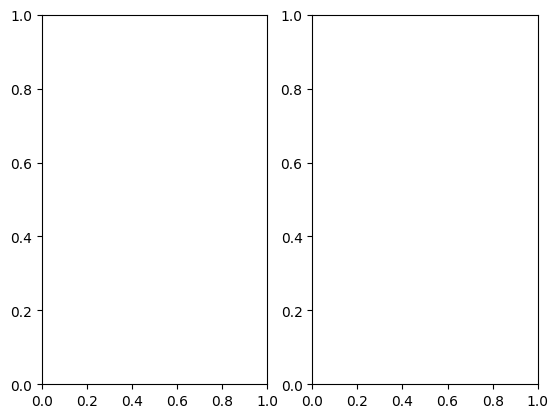

In [33]:
import matplotlib.pyplot as pcdlist
from PIL import Image

fig, axes = plt.subplots(1,2)

pcd_of_choice = 297
sud_pcd = Image.open("/home2/aneesh.chavan/FinderNetReimplementation/inference_pcds/anchor_DEMs/000" + str(pcd_of_choice) + ".png")

axes[0].imshow(sud_pcd)

# my DEM
pcd = o3d.io.read_point_cloud(os.path.join(bp, f"%.6d" % pcd_of_choice + ".ply"))
DEM, tx = generateDEM(direct_pcd=pcd)

axes[1].imshow(DEM)

fig.show()
